# Load data

In [1]:
before_debias_stereoset_results_dir = '../results/stereoset_processed'
before_debias_crows_results_dir = '../results/crows'

In [2]:
import os
import json

stereoset_result = {}
for file in os.listdir(before_debias_stereoset_results_dir):
    if file.endswith('.json'):
        with open(os.path.join(before_debias_stereoset_results_dir, file), 'r') as f:
            file_name = file.lower()
            # Go into first key
            stereoset_results_before = json.load(f)
            stereoset_result['gpt2' if 'gpt' in file_name else 'phi2' if 'phi' in file_name else 'llama2'] = stereoset_results_before[list(stereoset_results_before.keys())[0]]['intrasentence']
            
            
crows_result = {}
for file in os.listdir(before_debias_crows_results_dir):
    if file.endswith('.json'):
        with open(os.path.join(before_debias_crows_results_dir, file), 'r') as f:
            file_name = file.lower()
            crows_result['gpt2' if 'gpt' in file_name else 'phi2' if 'phi' in file_name else 'llama2'] = json.load(f)

In [3]:
print(stereoset_result)

{'llama2': {'gender': {'Count': 2313.0, 'LM Score': 88.9502105442635, 'SS Score': 66.28274452424877, 'ICAT Score': 59.98313947085586}, 'profession': {'Count': 7194.0, 'LM Score': 87.76614379532114, 'SS Score': 61.84370077111878, 'ICAT Score': 66.9766248963858}, 'race': {'Count': 8928.0, 'LM Score': 88.81205681695816, 'SS Score': 63.94939308275959, 'ICAT Score': 64.0345709963956}, 'religion': {'Count': 741.0, 'LM Score': 92.4522346488111, 'SS Score': 60.80819405810136, 'ICAT Score': 72.46740078502165}, 'overall': {'Count': 6392.0, 'LM Score': 88.57558590934867, 'SS Score': 63.338721363648354, 'ICAT Score': 64.94588470801469}}, 'phi2': {'gender': {'Count': 2313.0, 'LM Score': 91.6716883640172, 'SS Score': 68.80683140688139, 'ICAT Score': 57.19060860709237}, 'profession': {'Count': 7194.0, 'LM Score': 91.73349758135846, 'SS Score': 67.93298235825898, 'ICAT Score': 58.83239370560058}, 'race': {'Count': 8928.0, 'LM Score': 92.44955694926966, 'SS Score': 61.92097162788231, 'ICAT Score': 70.4

In [4]:
print(crows_result)

{'llama2': {'age': {'Anti-stereotype score': 50.0, 'Metric score': 72.41, 'Num. neutral': 0.0, 'Stereotype score': 76.71, 'Total examples': 87}, 'disability': {'Anti-stereotype score': None, 'Metric score': 80.0, 'Num. neutral': 0.0, 'Stereotype score': 84.21, 'Total examples': 60}, 'gender': {'Anti-stereotype score': 60.19, 'Metric score': 64.89, 'Num. neutral': 0.0, 'Stereotype score': 67.92, 'Total examples': 262}, 'nationality': {'Anti-stereotype score': 45.45, 'Metric score': 58.49, 'Num. neutral': 0.0, 'Stereotype score': 59.46, 'Total examples': 159}, 'physical-appearance': {'Anti-stereotype score': 54.55, 'Metric score': 76.19, 'Num. neutral': 0.0, 'Stereotype score': 80.77, 'Total examples': 63}, 'race-color': {'Anti-stereotype score': 34.88, 'Metric score': 68.8, 'Num. neutral': 0.0, 'Stereotype score': 71.88, 'Total examples': 516}, 'religion': {'Anti-stereotype score': 33.33, 'Metric score': 77.14, 'Num. neutral': 0.0, 'Stereotype score': 79.8, 'Total examples': 105}, 'sexu

# Radar chart for all models, 3 categories

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def all_models_category_radar_chart(crows_data, stereoset_data):
    categories = ['gender', 'race', 'religion']
    models = ['llama2', 'phi2', 'gpt2']
    
    angles = np.linspace(0, 2 * np.pi, len(categories) * 2, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    def get_crows_category(cat):
        if cat.lower() == 'race':
            return 'race-color'
        return cat.lower()

    max_values = np.zeros(len(angles) - 1)  # To store max values for each angle

    for model in models:
        values = []
        for cat in categories:
            values.append(stereoset_data[model][cat]['SS Score'])
            values.append(crows_data[model][get_crows_category(cat)]['Stereotype score'])
        values = np.concatenate((values, [values[0]]))  # complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.25)
        
        # Update max_values
        max_values = np.maximum(max_values, values[:-1])  # Exclude the last repeated value
    
    # Add data labels for max values with improved positioning
    for i, (angle, value) in enumerate(zip(angles[:-1], max_values)):  # Exclude the last repeated angle
        ha = 'left'
        va = 'bottom'
        xytext = (10, 10)
        
        # Adjust text alignment and position based on the angle
        if 0 <= angle < np.pi/2:  # Upper right quadrant
            ha = 'left'
            va = 'bottom'
        elif np.pi/2 <= angle < np.pi:  # Upper left quadrant
            ha = 'right'
            va = 'bottom'
            xytext = (-10, 10)
        elif np.pi <= angle < 3*np.pi/2:  # Lower left quadrant
            ha = 'right'
            va = 'top'
            xytext = (-10, -10)
        else:  # Lower right quadrant
            ha = 'left'
            va = 'top'
            xytext = (10, -10)
        
        ax.annotate(f'{value:.1f}', xy=(angle, value), xytext=xytext,
                    textcoords='offset points', ha=ha, va=va)
        
    ax.set_thetagrids(angles[:-1] * 180/np.pi, 
                      [f'{cat} ({dataset})' for cat in categories for dataset in ['Stereoset', 'Crows']])
    ax.set_ylim(0, 100)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Stereotype Scores Across Categories and Datasets")
    plt.tight_layout()
    plt.show()
    
    # Save chart in media dir
    fig.savefig('media/stereoset_crows_ss_scores.png')

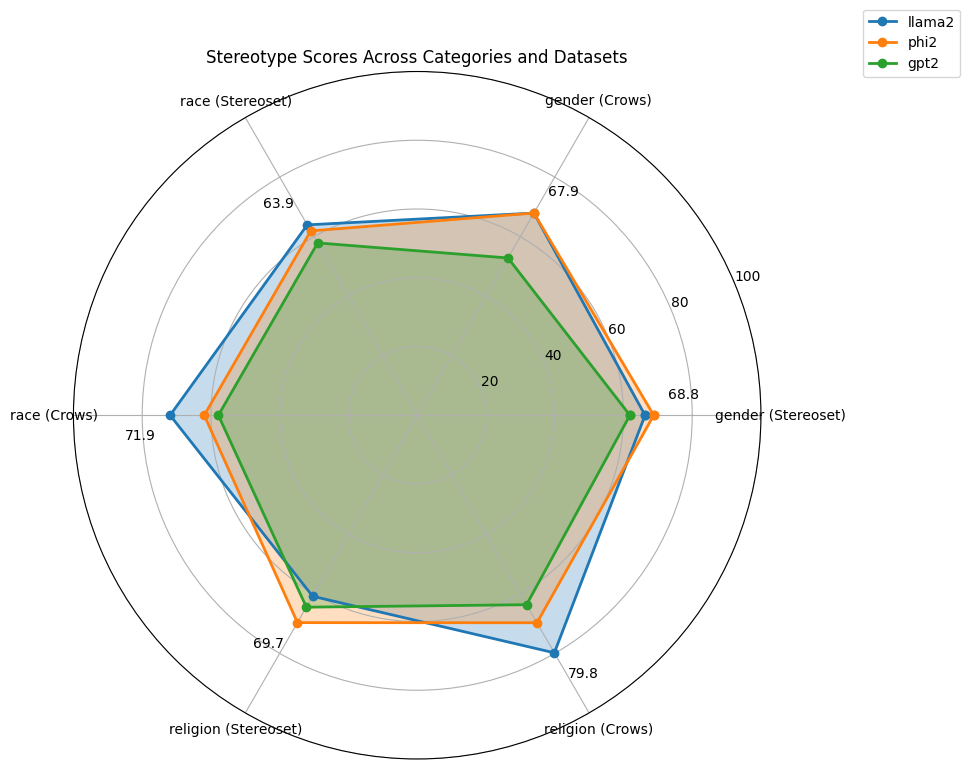

In [6]:
all_models_category_radar_chart(crows_result, stereoset_result)

# ICAT Score Bar chart for all models

In [7]:
def plot_lm_scores(stereoset):
    # Categories we want to plot
    categories = ['gender', 'religion', 'race']
    models = list(stereoset.keys())

    # Extracting LM scores for each model and category
    scores = {model: [stereoset[model][cat]['LM Score'] for cat in categories] for model in models}

    # Set up the bar chart
    x = np.arange(len(categories))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each model
    for i, (model, model_scores) in enumerate(scores.items()):
        offset = width * (i - 1)
        rects = ax.bar(x + offset, model_scores, width, label=model)
        
        # Add value labels on top of each bar
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Customize the chart
    ax.set_ylabel('LM Scores')
    ax.set_title('LM Scores Comparison Across Models and Categories')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Set y-axis range
    ax.set_ylim(85, 95)

    # Adjust layout and display the chart
    fig.tight_layout()
    plt.show()
    
    # Save chart in media dir
    fig.savefig('media/stereoset_LM_scores.png')

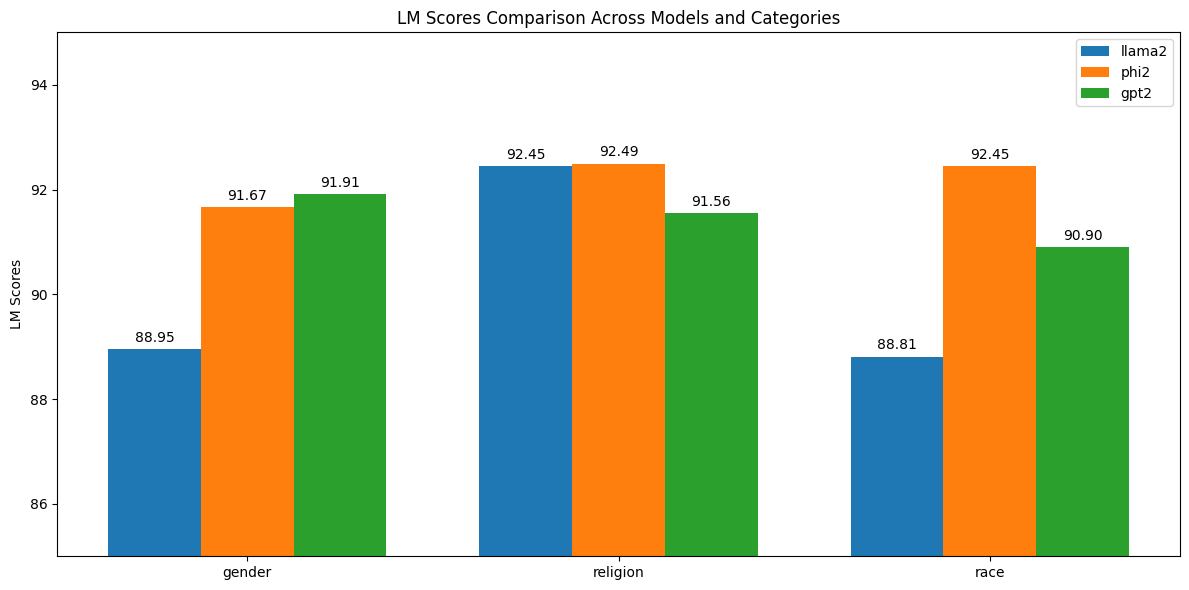

In [8]:
plot_lm_scores(stereoset_result)

In [9]:
def plot_icat_scores(stereoset):
       # Categories we want to plot
    categories = ['gender', 'religion', 'race']
    models = list(stereoset.keys())

    # Extracting LM scores for each model and category
    scores = {model: [stereoset[model][cat]['ICAT Score'] for cat in categories] for model in models}

    # Set up the bar chart
    x = np.arange(len(categories))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each model
    for i, (model, model_scores) in enumerate(scores.items()):
        offset = width * (i - 1)
        rects = ax.bar(x + offset, model_scores, width, label=model)
        
        # Add value labels on top of each bar
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Customize the chart
    ax.set_ylabel('ICAT Scores')
    ax.set_title('ICAT Scores Comparison Across Models and Categories')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Set y-axis range
    ax.set_ylim(50, 80)

    # Adjust layout and display the chart
    fig.tight_layout()
    plt.show()
    
    # Save chart in media dir
    fig.savefig('media/stereoset_icat_scores.png')

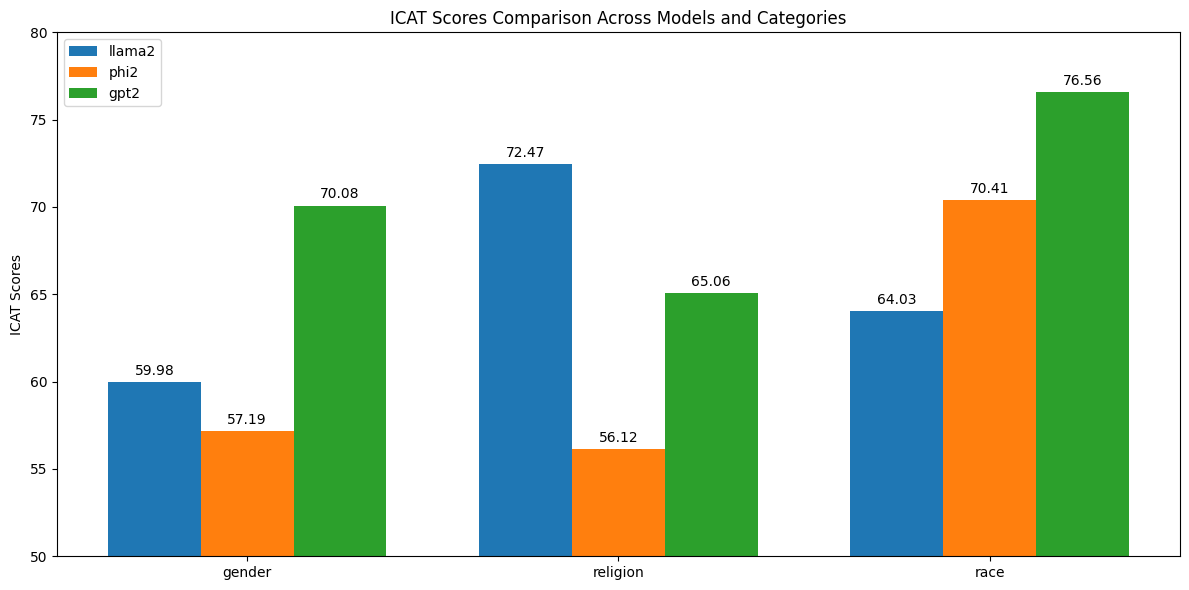

In [10]:
plot_icat_scores(stereoset_result)

# Crows metric score barchart

In [11]:
def plot_metric_score_barchart(crows):
    # Extract relevant data
    categories = ['gender', 'race-color', 'religion']
    models = list(crows.keys())
    
    # Prepare data for plotting
    x = np.arange(len(categories))
    width = 0.25
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        scores = [crows[model][cat]['Metric score'] for cat in categories]
        ax.bar(x + i*width, scores, width, label=model)
    
    # Customize the plot
    ax.set_ylabel('Metric Score')
    ax.set_title('Metric Scores Across Categories and Models')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Add value labels on top of each bar
    for i, model in enumerate(models):
        scores = [crows[model][cat]['Metric score'] for cat in categories]
        for j, score in enumerate(scores):
            ax.text(j + i*width, score, f'{score:.2f}', ha='center', va='bottom')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Save chart in media dir
    fig.savefig('media/crows_metric_score.png')

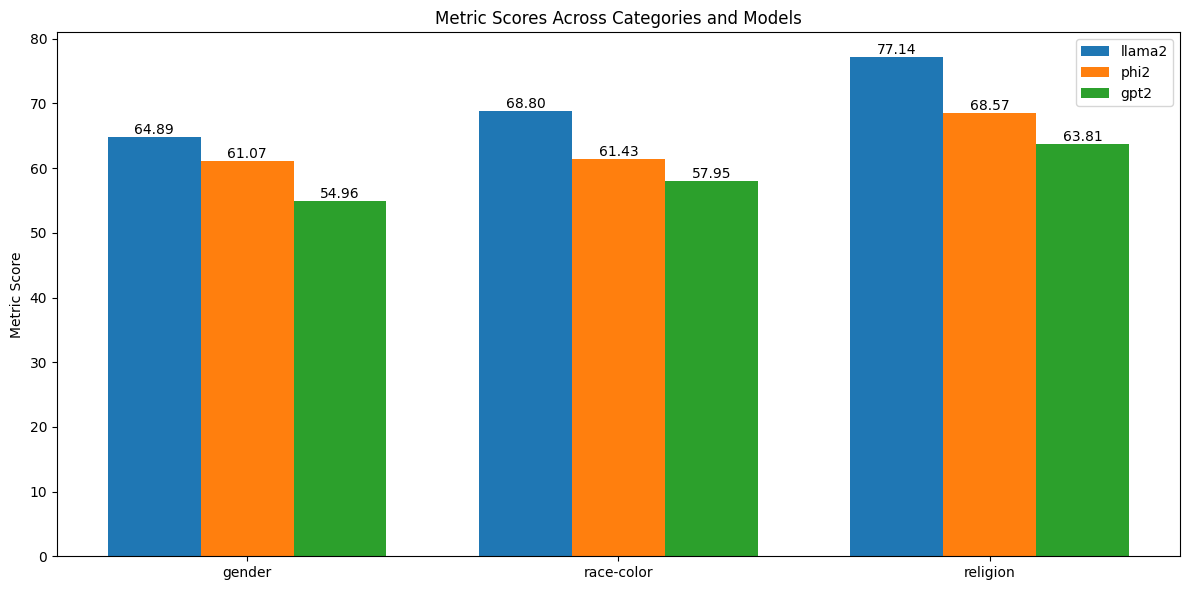

In [12]:
plot_metric_score_barchart(crows_result)

In [13]:
def plot_anti_stereotype_score_barchart(crows):
    # Extract relevant data
    categories = ['gender', 'race-color', 'religion']
    models = list(crows.keys())
    
    # Prepare data for plotting
    x = np.arange(len(categories))
    width = 0.25
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        scores = [crows[model][cat]['Anti-stereotype score'] for cat in categories]
        ax.bar(x + i*width, scores, width, label=model)
    
    # Customize the plot
    ax.set_ylabel('Anti-stereotype Score')
    ax.set_title('Anti-stereotype Scores Across Categories and Models')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Add value labels on top of each bar
    for i, model in enumerate(models):
        scores = [crows[model][cat]['Anti-stereotype score'] for cat in categories]
        for j, score in enumerate(scores):
            if score is not None:
                ax.text(j + i*width, score, f'{score:.2f}', ha='center', va='bottom')
            else:
                ax.text(j + i*width, 0, 'N/A', ha='center', va='bottom')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Save chart in media dir
    fig.savefig('media/crows_anti_stereotype_score.png')

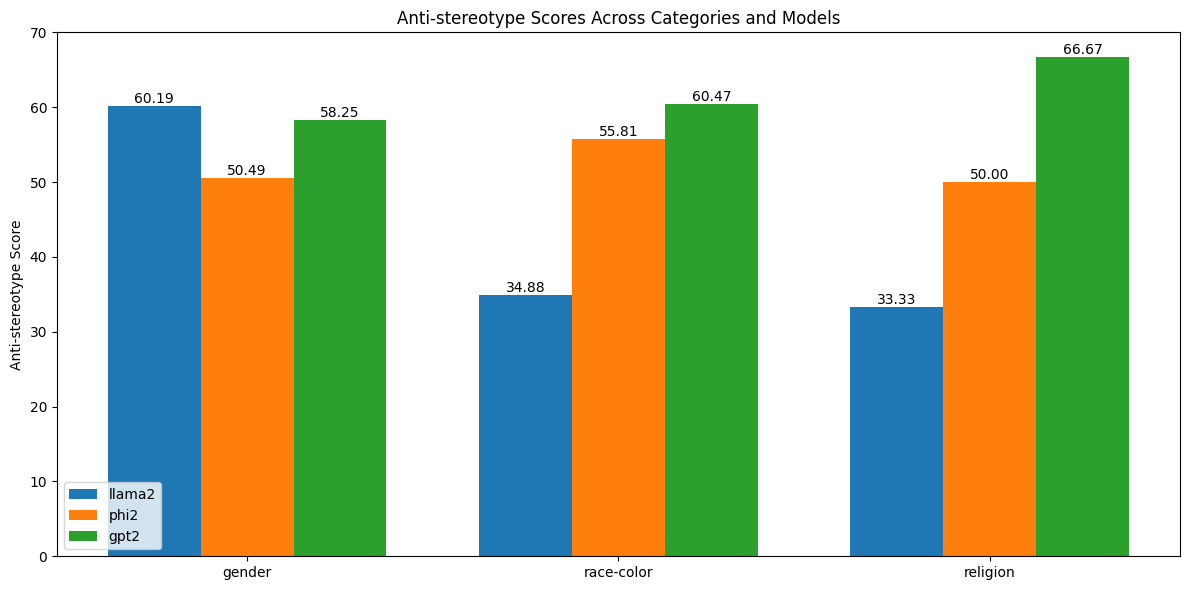

In [14]:
plot_anti_stereotype_score_barchart(crows_result)